<a href="https://colab.research.google.com/github/naraB/handson-ml-notes/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

In [0]:
import numpy as np

## Downloading the dataset

In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure: 

* *DESCR* key describing the dataset
* *data* key containing an array with one row per instance and one column per feature
* *target* key containing an array with labels

In [17]:
X,y = mnist['data'], mnist['target']
print('X shape', X.shape)
print('y shape', y.shape)

X shape (70000, 784)
y shape (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 * 28 pixels, and each feature simply represents one pixel's instensity, from 0 (white) to 255 (black). Lets take apeek at one digit from the dataset. All we need to do is grab an instance's feature vector, reshapre it to a 28 * 28 array, and display it using Matplotlib's imhsow() function:

(784,)


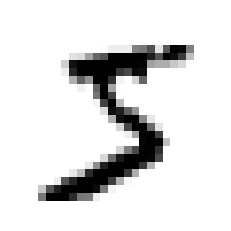

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [19]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so lets cast y to integer:

In [0]:
y = y.astype(np.uint8)

## Creating test and train set

The MNIST dataset is already split into a training set (the first 60,000 images) and test set (the last 10,000 images)

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training data is already shuffled for us

## Binary Classification

Let's simplify the problem for now and only tr to identify one digit - for example, te number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Training

Let's use a *Stochastic Gradient Descent* (SGD) classifier, Scikit-learn's SGDClassifier class.

The classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5:

In [24]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available.

#### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation